
#### <center>DVD Rental Co<center>
## <center>Exploratory Data Analysis<center>
### <center>Dive into the legacy data: Migration, Analysis and Key Insights<center>

PLEASE READ: All the questions from the lab are answered below, should you feel that I passed too fast or missed to mention something in the video, feel free to scroll down. Thank you!

In [19]:
import duckdb
with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

In [20]:
dfs = {}
with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        if name[0] != "_":
            dfs[name] = conn.sql(f"FROM staging.{name};").df()
            duckdb.register(name, dfs[name])
#dfs.keys()

### Task 1
a) Which movies are longer than 3 hours (180 minutes), show the title and its length?


In [21]:
over_3h_movies = duckdb.sql("""
        SELECT 
            title, 
            length as "Length (minutes)"
        FROM 
            film
        WHERE 
            "length (minutes)"> 180
        ORDER BY 
            "length (minutes)" DESC;
    """).df()
over_3h_movies.head()

,title,Length (minutes)
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185


b) Which movies have the word "love" in its title? Show the following columns

In [22]:
love_in_titles = duckdb.sql("""
        SELECT 
            title, rating, length, description
        FROM 
            film
        WHERE 
            regexp_matches(title, '(?i)\\blove\\b');
    """).df()
love_in_titles

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and
longest movie length

In [23]:
film_duration = duckdb.sql(""" 
    SELECT
        MIN(length) as shortest_duration,
        ROUND(AVG(length)) as mean_duration,
        MEDIAN(length) as median_duration, 
        MAX(length) as longest_duration 
    FROM
        film;
    """).df()
film_duration

,shortest_duration,mean_duration,median_duration,longest_duration
0,46,115.0,114.0,185


d) The Manager wants to know the 10 most expensive movies to rent per day

In [24]:
expensive_rentals = duckdb.sql(""" 
    SELECT 
        title, 
        rental_duration, 
        rental_rate, 
        ROUND(rental_rate/rental_duration, 2) AS "Price/Day"
    FROM
        film
    ORDER BY
        "Price/Day" DESC
    LIMIT 10;
    """).df()
expensive_rentals

,title,rental_duration,rental_rate,Price/Day
0,AMERICAN CIRCUS,3,4.99,1.66
1,BACKLASH UNDEFEATED,3,4.99,1.66
2,BILKO ANONYMOUS,3,4.99,1.66
3,BEAST HUNCHBACK,3,4.99,1.66
4,CARIBBEAN LIBERTY,3,4.99,1.66
5,AUTUMN CROW,3,4.99,1.66
6,CASPER DRAGONFLY,3,4.99,1.66
7,ACE GOLDFINGER,3,4.99,1.66
8,BEHAVIOR RUNAWAY,3,4.99,1.66
9,CASUALTIES ENCINO,3,4.99,1.66


e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have
played in.


In [25]:
top_10_actors = duckdb.sql(""" 
    SELECT
        a.actor_id, 
        a.first_name || ' ' || a.last_name AS actor_name,
        COUNT(fa.film_id) AS movie_count
    FROM
        actor a
    JOIN 
        film_actor fa ON a.actor_id = fa.actor_id
    GROUP BY
        a.actor_id, a.first_name, a.last_name
    ORDER BY
        movie_count DESC
    LIMIT 10;
    """).df()
top_10_actors

,actor_id,actor_name,movie_count
0,107.0,GINA DEGENERES,42
1,102.0,WALTER TORN,41
2,198.0,MARY KEITEL,40
3,181.0,MATTHEW CARREY,39
4,23.0,SANDRA KILMER,37
5,81.0,SCARLETT DAMON,36
6,37.0,VAL BOLGER,35
7,60.0,HENRY BERRY,35
8,106.0,GROUCHO DUNST,35
9,13.0,UMA WOOD,35


f) Now it's time for you to choose your own question to explore the sakila database! Write down 3-5
questions you want to answer and then answer them using pandas and duckdb.<br>

Question f1: Which are the top 3 most rented film categories?

In [26]:
top_3_categories = duckdb.sql("""
    SELECT
        c.name as Category,
        COUNT(r.rental_id) as total_rentals 
    FROM
        category c 
    JOIN film_category fc ON c.category_id = fc.category_id 
    JOIN film f ON fc.film_id = f.film_id 
    JOIN inventory inv ON f.film_id = inv.film_id
    JOIN rental r ON inv.inventory_id = r.inventory_id 
    GROUP BY
        c.name 
    ORDER BY
        total_rentals DESC 
    LIMIT 3;
    """).df()
top_3_categories

,Category,total_rentals
0,Sports,1179
1,Animation,1166
2,Action,1112


Question f2: Who are the churned customers (full name, email, last rental date) to email them a voucher to reactivate them

In [27]:
check_active = duckdb.sql("DESC customer;").df()
check_active
# Note: active is a str/VARCHAR, not Boolean

,column_name,column_type,null,key,default,extra
0,customer_id,BIGINT,YES,None,None,None
1,store_id,BIGINT,YES,None,None,None
2,first_name,VARCHAR,YES,None,None,None
3,last_name,VARCHAR,YES,None,None,None
4,email,VARCHAR,YES,None,None,None
5,address_id,BIGINT,YES,None,None,None
6,active,VARCHAR,YES,None,None,None
7,create_date,TIMESTAMP,YES,None,None,None
8,last_update,TIMESTAMP,YES,None,None,None
9,_dlt_load_id,VARCHAR,YES,None,None,None


In [28]:
# active is a str/VARCHAR with '0' and '1'
check_active2 = duckdb.sql(""" 
    SELECT
        active,
        COUNT(*) as active_count
    FROM
        customer
    GROUP BY active 
    ORDER BY active_count;
    """).df()
check_active2

,active,active_count
0,0,15
1,1,584


In [29]:
churn_cust_list = duckdb.sql(""" 
    SELECT
        cust.customer_id, 
        CONCAT(cust.first_name,' ', cust.last_name) AS customer_name, 
        MIN(r.rental_date) as first_rental, 
        MAX(r.rental_date) as last_rental, 
        cust.email, 
    FROM
        customer cust 
    LEFT JOIN rental r ON cust.customer_id =  r.customer_id 
    WHERE cust.active = '0' 
    GROUP BY ALL 
    ORDER BY customer_name;
    """).df()
churn_cust_list

,customer_id,customer_name,first_rental,last_rental,email
0,510,BEN EASTER,2005-05-25 11:13:34,2005-08-22 10:46:44,BEN.EASTER@sakilacustomer.org
1,534,CHRISTIAN JUNG,2005-05-26 21:21:28,2006-02-14 15:16:03,CHRISTIAN.JUNG@sakilacustomer.org
2,169,ERICA MATTHEWS,2005-05-28 04:28:38,2005-08-23 09:33:22,ERICA.MATTHEWS@sakilacustomer.org
3,368,HARRY ARCE,2005-05-25 09:21:29,2005-08-23 00:31:09,HARRY.ARCE@sakilacustomer.org
4,241,HEIDI LARSON,2005-05-28 17:04:43,2005-08-23 13:14:15,HEIDI.LARSON@sakilacustomer.org
5,558,JIMMIE EGGLESTON,2005-06-17 09:19:52,2005-08-21 06:53:53,JIMMIE.EGGLESTON@sakilacustomer.org
6,64,JUDITH COX,2005-05-28 00:39:31,2006-02-14 15:16:03,JUDITH.COX@sakilacustomer.org
7,315,KENNETH GOODEN,2005-05-28 06:20:55,2006-02-14 15:16:03,KENNETH.GOODEN@sakilacustomer.org
8,482,MAURICE CRAWLEY,2005-05-26 15:32:46,2005-08-23 16:42:53,MAURICE.CRAWLEY@sakilacustomer.org
9,406,NATHAN RUNYON,2005-05-30 02:00:28,2005-08-21 17:45:52,NATHAN.RUNYON@sakilacustomer.org


Question f3: Which store generated the least revenues in 2006?

In [30]:
# First how many stores are there?
stores_count = duckdb.sql(""" 
    SELECT 
        COUNT(*) AS store_count 
    FROM store;
    """).df()
stores_count

,store_count
0,2


In [31]:
# How many business years?
rental_years = duckdb.sql(""" 
    SELECT 
        DISTINCT YEAR(rental_date) as rental_year 
    FROM rental 
    ORDER BY rental_year;
    """).df()
rental_years

,rental_year
0,2005
1,2006


In [32]:
revenue_stores_2006 = duckdb.sql("""
    SELECT 
        s.store_id, 
        CONCAT(ad.address, ', ', ci.city, ', ', cou.country) AS full_address, 
        SUM(p.amount) AS total_revenue, 
    FROM 
        payment p 
    JOIN rental r ON p.rental_id = r.rental_id 
    JOIN inventory i ON r.inventory_id = i.inventory_id 
    JOIN store s ON i.store_id = s.store_id 
    JOIN address ad ON s.address_id = ad.address_id 
    JOIN city ci ON ad.city_id = ci.city_id 
    JOIN country cou ON ci.country_id = cou.country_id 
    WHERE
        EXTRACT(YEAR FROM p.payment_date) = 2006 
    GROUP BY 
        s.store_id, ad.address, ci.city, cou.country  
    ORDER BY
        total_revenue ASC;
    """).df()
revenue_stores_2006                         

,store_id,full_address,total_revenue
0,1,"47 MySakila Drive, Lethbridge, Canada",243.10
1,2,"28 MySQL Boulevard, Woodridge, Australia",271.08


In [33]:
# Checking the above as very low numbers
sales_check_2006 = duckdb.sql(""" 
    SELECT 
        s.store_id, 
        EXTRACT(MONTH FROM p.payment_date) AS month, 
        COUNT(p.payment_id) AS rentals_transaction, 
        ROUND(SUM(p.amount), 2) AS revenue, 
    FROM 
        payment p 
    JOIN rental r ON p.rental_id = r.rental_id
    JOIN inventory i ON r.inventory_id = i.inventory_id
    JOIN store s ON i.store_id = s.store_id                    
    WHERE
        EXTRACT(YEAR FROM p.payment_date) = 2006 
    GROUP BY
        s.store_id, EXTRACT(MONTH FROM p.payment_date), 
    ORDER BY
        s.store_id, month;
    """).df() 
sales_check_2006

,store_id,month,rentals_transaction,revenue
0,1,2,92,243.10
1,2,2,90,271.08


In [34]:
# Checking if transactions numbers match, should be 182 in 2006 
check_monthly_transactions = duckdb.sql("""
    SELECT 
        EXTRACT(YEAR FROM payment_date) AS year, 
        EXTRACT(MONTH FROM payment_date) AS month, 
        COUNT(p.payment_id) AS transactions, 
        ROUND(SUM(p.amount), 2) AS revenue
    FROM
        payment p 
    GROUP BY ALL 
    ORDER BY
        year, month;
    """).df()
check_monthly_transactions

,year,month,transactions,revenue
0,2005,5,1157,4824.43
1,2005,6,2312,9631.88
2,2005,7,6711,28373.89
3,2005,8,5687,24072.13
4,2006,2,182,514.18


Question f4: What ratings have our films? Is it what we want?

In [43]:
rating_overview = duckdb.sql("""
    SELECT
        distinct rating,
        COUNT(*) AS "Number of films"
    FROM film 
    GROUP BY rating
    ORDER BY "Number of films" DESC;
""").df()
rating_overview

,rating,Number of films
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


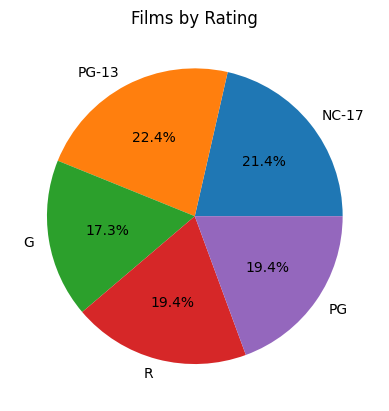

In [ ]:
# Pide code source: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
ratings = ['NC-17', 'PG-13', 'G', 'R', 'PG']
sizes = [21, 22, 17, 19, 19]
plt.pie(sizes, labels=ratings, autopct='%1.1f%%')
plt.title('Films by Rating')
plt.show()

### Task 2 - graphs
a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them
with special offers. Create a bar chart showing the top 5 customers by total spend.

In [36]:
top_5_customers = duckdb.sql(""" 
    SELECT 
        cust.customer_id, 
        cust.first_name || ' ' || cust.last_name AS customer, 
        SUM(p.amount) AS total_spend 
    FROM
        customer cust 
    JOIN main.payment p ON cust.customer_id = p.customer_id 
    GROUP BY
        cust.customer_id, customer 
    ORDER BY
        total_spend DESC 
    LIMIT 5;
    """).df()
top_5_customers

,customer_id,customer,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,137,RHONDA KENNEDY,194.61
4,178,MARION SNYDER,194.61


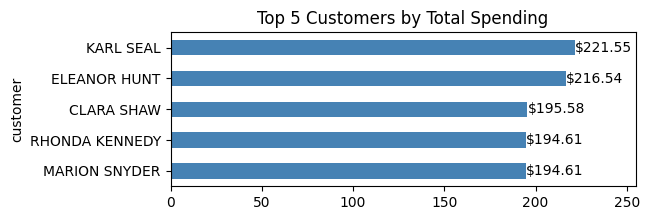

In [37]:
ax = top_5_customers.plot(
    kind='barh',              
    x='customer',             
    y='total_spend',
    figsize=(6, 2),
    color='steelblue',
    legend=False,
    title='Top 5 Customers by Total Spending'
    )
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='$%.2f') # took from LLM to make values appear 
ax.margins(x=0.15)                          # took from LLM to make values appear   

b) How much money does each film category bring in? Make a bar chart showing total revenue per film
category.


In [38]:
revenue_per_category = duckdb.sql("""
    SELECT
        c.name AS category_name,
        SUM(p.amount) AS revenues                                              
    FROM
        category c
    LEFT JOIN film_category fc ON c.category_id = fc.category_id
    LEFT JOIN film f ON fc.film_id = f.film_id
    LEFT JOIN inventory inv ON f.film_id = inv.film_id
    LEFT JOIN rental r ON inv.inventory_id = r.inventory_id
    LEFT JOIN payment p ON r.rental_id = p.rental_id
    GROUP BY c.name
    ORDER BY revenues DESC;
""").df()
revenue_per_category

,category_name,revenues
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


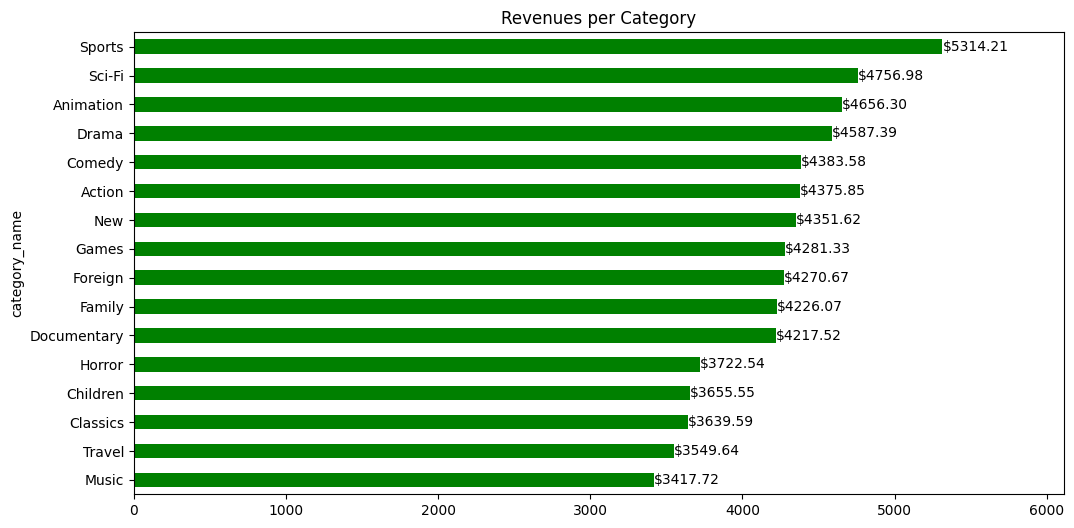

In [39]:
ax = revenue_per_category.plot(
    kind='barh',              
    x='category_name',             
    y='revenues',
    figsize=(12, 6),
    color='green',
    legend=False,
    title='Revenues per Category'
    )
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='$%.2f') 
ax.margins(x=0.15)               

### Task 3 - BI report
